# Прогнозирование криптовалют с помощью методов машинного обучения

### Импортируем необходимые библиотеки и функции

In [256]:
pip install sktime

In [257]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sktime.forecasting.model_selection import temporal_train_test_split
from statsmodels.tsa.api import VAR
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sktime.utils.plotting import plot_correlations
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Скачиваем котировки топ-25 криптовалют по капитализации

In [258]:
tickers = ["BTC-USD", "ETH-USD", "BNB-USD", "USDC-USD",
           "XRP-USD", "ADA-USD", "SOL-USD", "DOGE-USD", "DOT-USD",
           "TRX-USD", "SHIB-USD", "AVAX-USD", "MATIC-USD", "UNI-USD",
           "WBTC-USD", "LINK-USD", "ATOM-USD", "XMR-USD", "ETC-USD",
           "LTC-USD", "FTT-USD", "BCH-USD", "NEAR-USD", "ALGO-USD"]

prices = pd.DataFrame()
for ticker in tickers:
  price = yf.download(
      tickers = ticker,
      start = '2009-01-01',
      end = '2024-06-01',
      auto_adjust = True
  )
  price = pd.DataFrame(price['Close']).rename(columns = {'Close': ticker})
  prices = pd.concat([prices, price], axis=1)

prices.index = pd.to_datetime(prices.index)
prices = prices.resample('W').mean()
prices_pct = prices.pct_change()

prices.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,BTC-USD,ETH-USD,BNB-USD,USDC-USD,XRP-USD,ADA-USD,SOL-USD,DOGE-USD,DOT-USD,TRX-USD,...,WBTC-USD,LINK-USD,ATOM-USD,XMR-USD,ETC-USD,LTC-USD,FTT-USD,BCH-USD,NEAR-USD,ALGO-USD
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-21,416.859003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.520782,NaN,NaN,NaN,NaN
2014-09-28,407.692566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.465569,NaN,NaN,NaN,NaN
2014-10-05,361.426570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.183600,NaN,NaN,NaN,NaN
2014-10-12,355.234580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.845704,NaN,NaN,NaN,NaN
2014-10-19,390.479854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.003281,NaN,NaN,NaN,NaN


### Проверяем их на наличие пропусков и отбираем те, в которых число пропусков <=164

In [259]:
prices.isnull().sum()

BTC-USD        0
ETH-USD      164
BNB-USD      164
USDC-USD     212
XRP-USD      164
ADA-USD      164
SOL-USD      290
DOGE-USD     164
DOT-USD      309
TRX-USD      164
SHIB-USD     306
AVAX-USD     313
MATIC-USD    240
UNI-USD      266
WBTC-USD     228
LINK-USD     164
ATOM-USD     234
XMR-USD      164
ETC-USD      164
LTC-USD        0
FTT-USD      254
BCH-USD      164
NEAR-USD     317
ALGO-USD     248
dtype: int64

In [260]:
n = len(list(prices.isnull().sum()[prices.isnull().sum()<=164]))
tickers = [tickers[i] for i in np.argpartition(np.array(prices.isnull().sum()), n, axis=-1)[:n]]
tickers

['BTC-USD',
 'DOGE-USD',
 'XMR-USD',
 'ETH-USD',
 'ETC-USD',
 'TRX-USD',
 'LTC-USD',
 'LINK-USD',
 'BNB-USD',
 'BCH-USD',
 'XRP-USD',
 'ADA-USD']

In [261]:
prices = prices[tickers].dropna()
if 'USDT-USD' in tickers:
  prices = prices.drop(['USDT-USD'], axis=1)
prices.head()

,BTC-USD,DOGE-USD,XMR-USD,ETH-USD,ETC-USD,TRX-USD,LTC-USD,LINK-USD,BNB-USD,BCH-USD,XRP-USD,ADA-USD
Date,,,,,,,,,,,,
2017-11-12,6813.745675,0.001204,117.459499,310.681496,15.854300,0.002036,60.554357,0.190560,1.744442,1097.758224,0.207935,0.027647
2017-11-19,7416.871512,0.001312,124.915999,336.145717,17.325742,0.002163,66.823129,0.174280,1.598004,1193.250872,0.219936,0.026613
2017-11-26,8419.911342,0.001786,156.271855,418.638000,19.683143,0.002128,77.158471,0.172403,1.686239,1479.362880,0.242735,0.029866
2017-12-03,10481.822684,0.002147,188.416142,460.533722,29.401243,0.002141,94.584128,0.184665,1.998604,1482.261440,0.258681,0.110778
2017-12-10,14709.728655,0.002610,260.553713,452.533578,28.731571,0.003548,119.146487,0.261725,2.625584,1433.865723,0.241315,0.118865


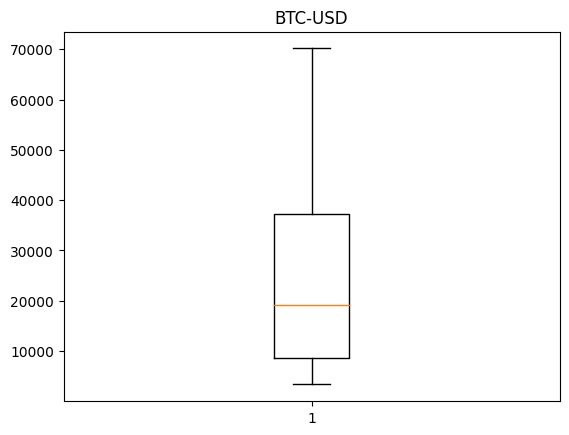

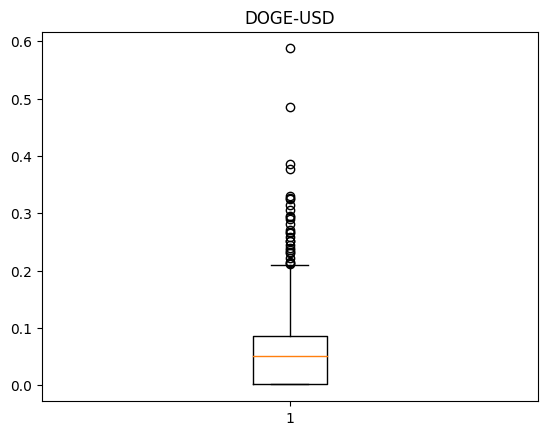

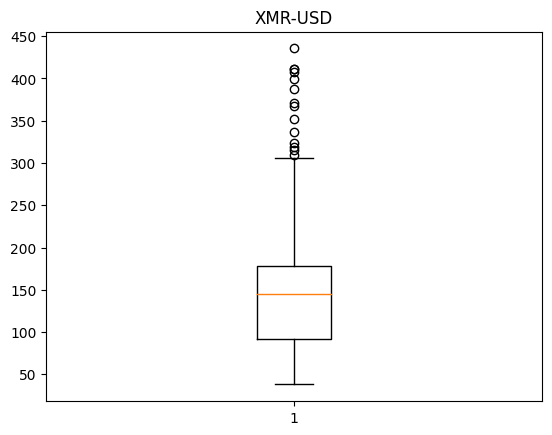

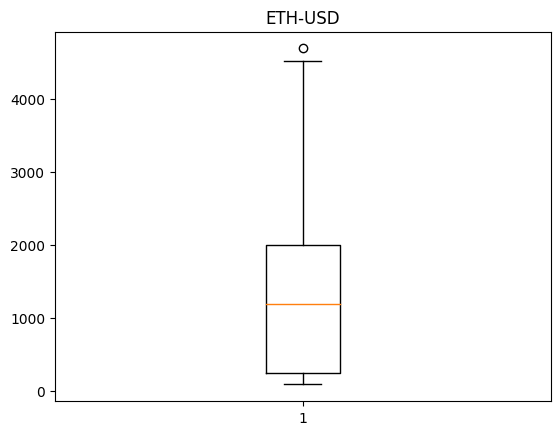

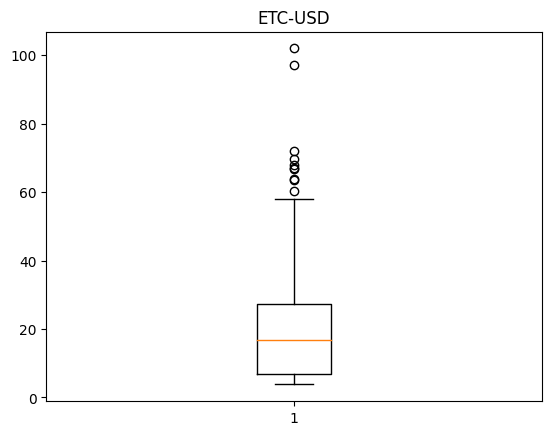

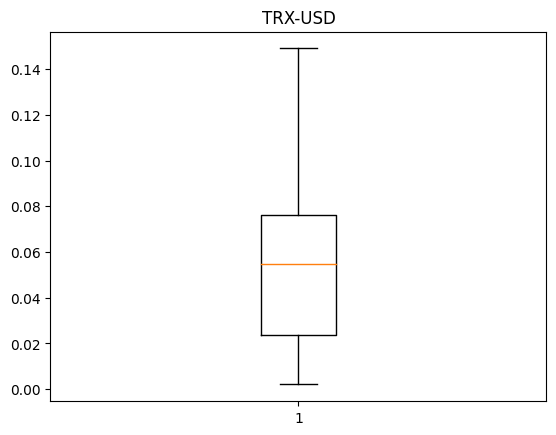

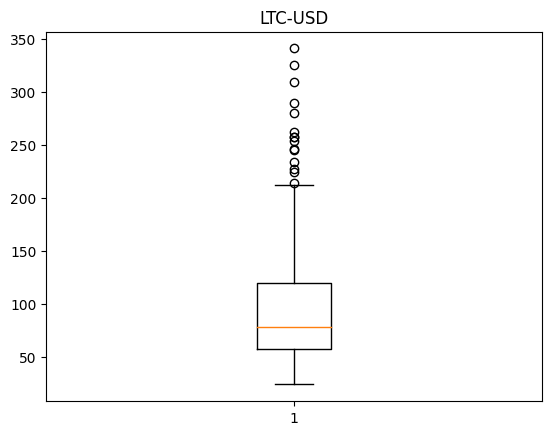

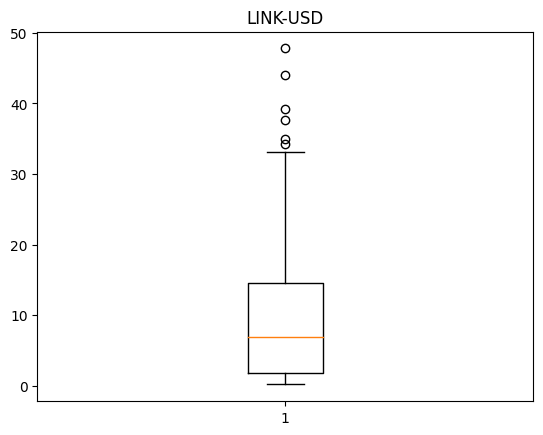

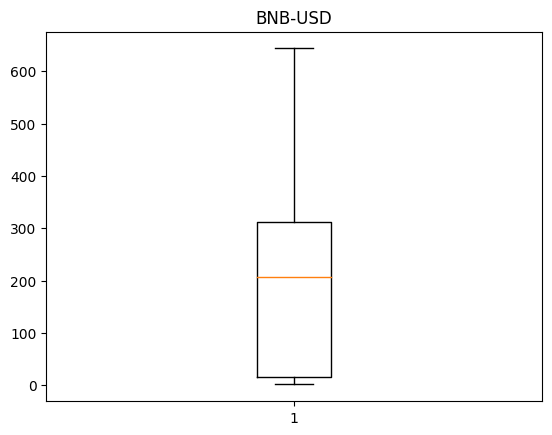

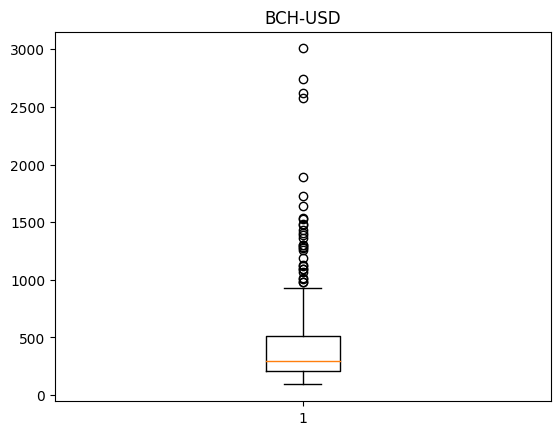

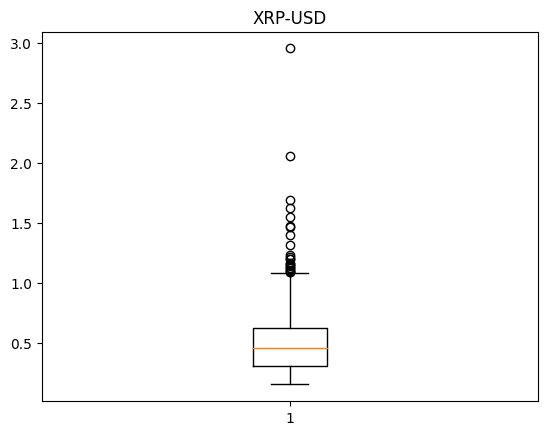

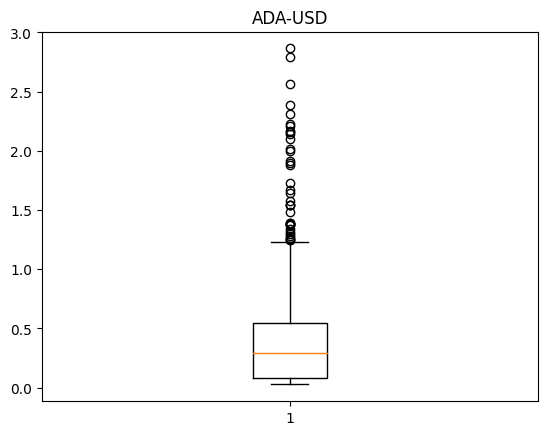

In [262]:
for i in prices.columns:
  plt.title(i)
  plt.boxplot(prices[i])
  plt.show()

Исходя из BoxPlot, можем увидеть, что на некоторых криптовалютах количество выбросов очень большое. Лучше удалить эти тикеры из датафрейма, т.к. иначе придется удалять большое количество строк и в итоге это может сказаться на качестве модели.

In [263]:
new_tickers = []
for i in tickers:
  if i not in ['DOGE-USD', 'XMR-USD', 'ADA-USD', 'BCH-USD', 'XRP-USD', 'LTC-USD']:
    new_tickers.append(i)
prices = prices[new_tickers]
for i in new_tickers:
  Q1 = prices[i].quantile(0.25)
  Q3 = prices[i].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  prices = prices[(prices[i]>=lower_bound) & (prices[i] <= upper_bound)]
prices = prices.interpolate()

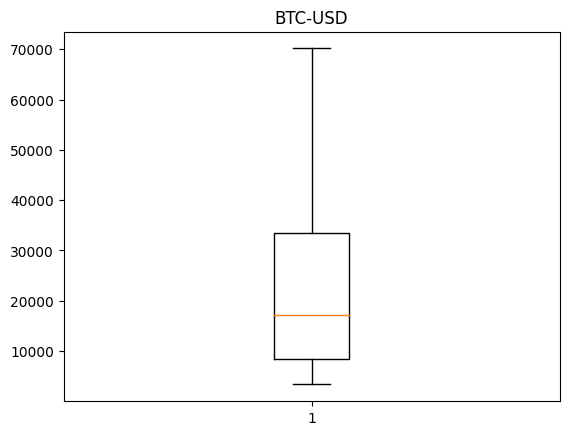

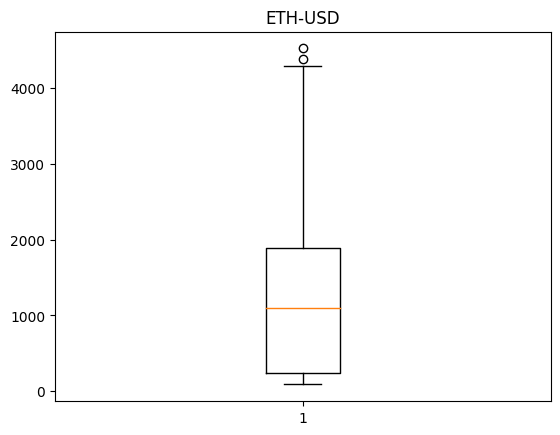

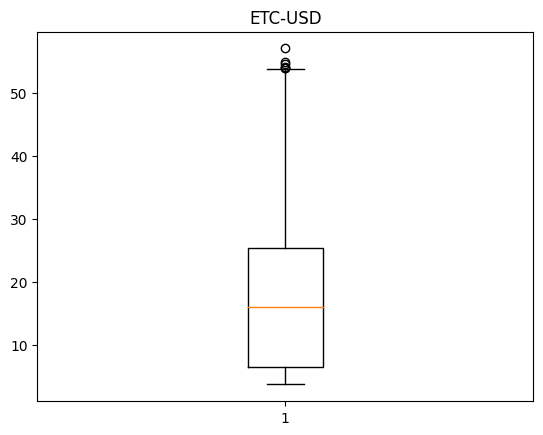

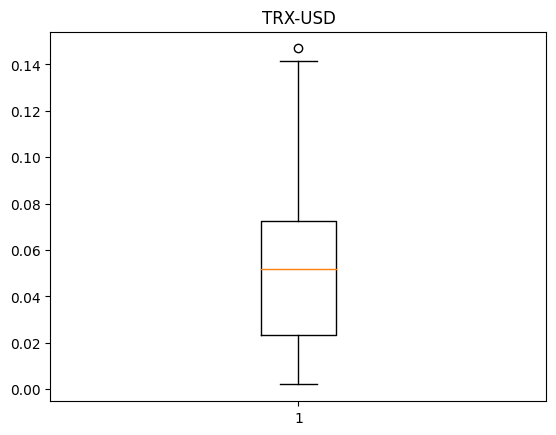

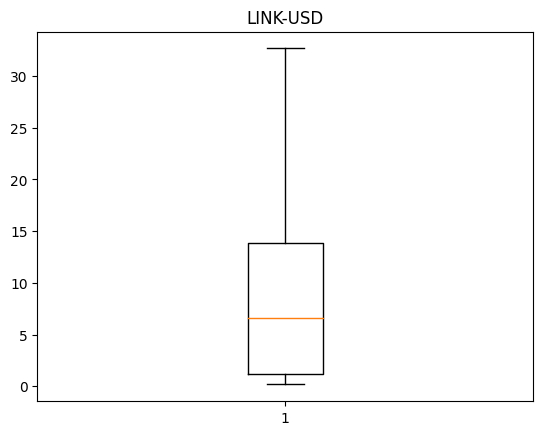

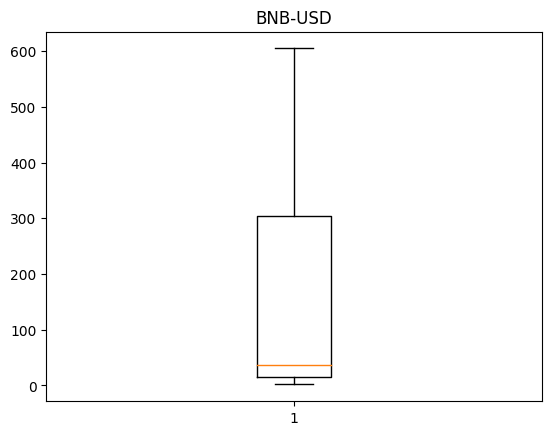

In [264]:
for i in prices.columns:
  plt.title(i)
  plt.boxplot(prices[i])
  plt.show()

In [265]:
prices

,BTC-USD,ETH-USD,ETC-USD,TRX-USD,LINK-USD,BNB-USD
Date,,,,,,
2017-11-12,6813.745675,310.681496,15.854300,0.002036,0.190560,1.744442
2017-11-19,7416.871512,336.145717,17.325742,0.002163,0.174280,1.598004
2017-11-26,8419.911342,418.638000,19.683143,0.002128,0.172403,1.686239
2017-12-03,10481.822684,460.533722,29.401243,0.002141,0.184665,1.998604
2017-12-10,14709.728655,452.533578,28.731571,0.003548,0.261725,2.625584
...,...,...,...,...,...,...
2024-05-05,61809.694754,3077.719482,26.543719,0.121046,13.850105,579.750227
2024-05-12,61824.221540,2975.582694,26.929772,0.124206,13.866845,588.895176
2024-05-19,65174.908482,3014.516567,27.212919,0.124451,14.985303,577.981384


### Корреляции и автокорреляции криптовалют

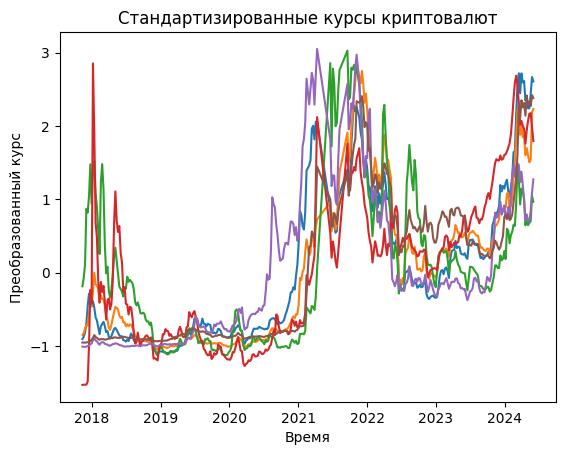

In [266]:
scaler = StandardScaler()
scaler.fit(prices)
prices_scaled = pd.DataFrame(scaler.transform(prices), index=prices.index, columns=prices.columns)
plt.title('Стандартизированные курсы криптовалют')
plt.xlabel('Время')
plt.ylabel('Преобразованный курс')
plt.plot(prices_scaled);

График движения стандартизированных цен явно показывает наличие общих трендов у криптовалют

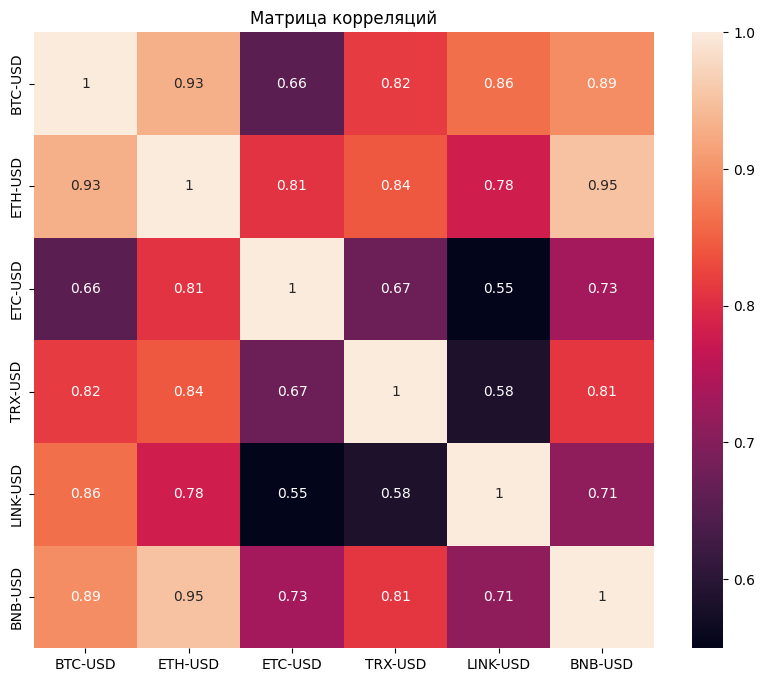

In [267]:
plt.figure(figsize=(10, 8))
plt.title('Матрица корреляций')
sns.heatmap(prices.corr(), annot=True)
plt.show()

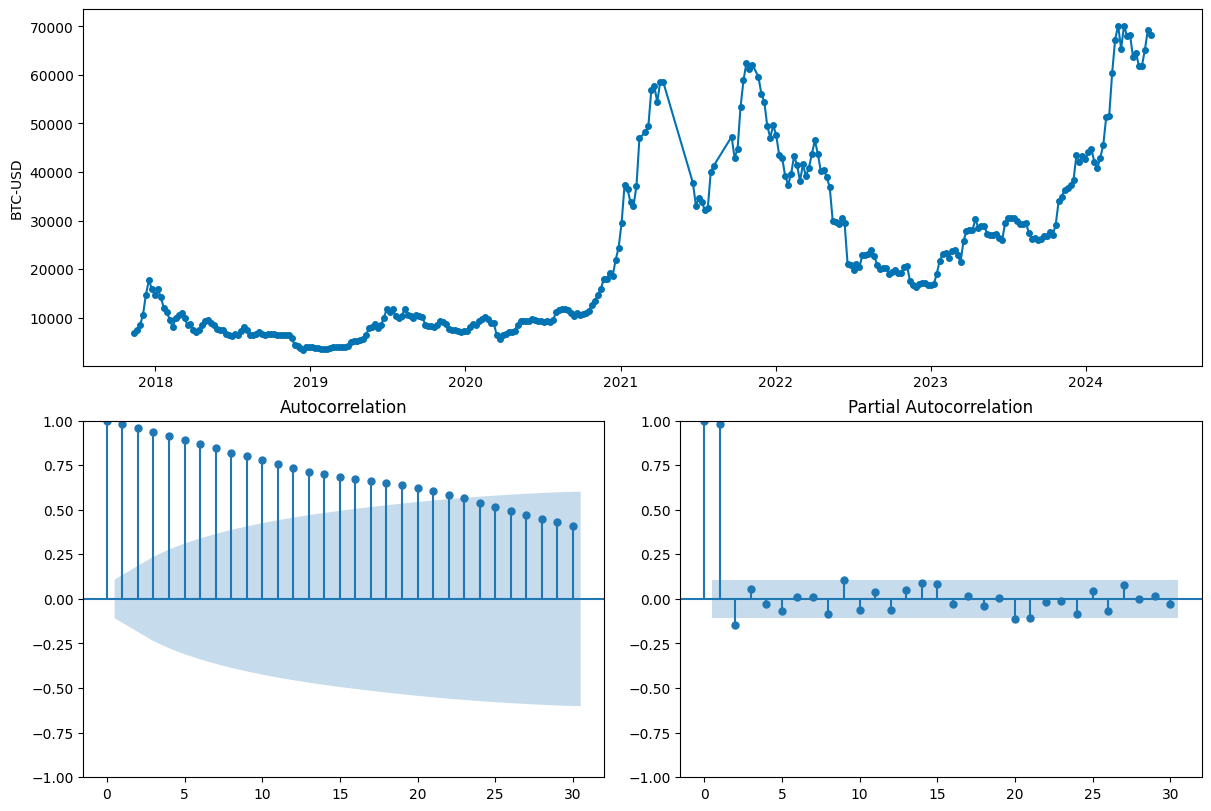

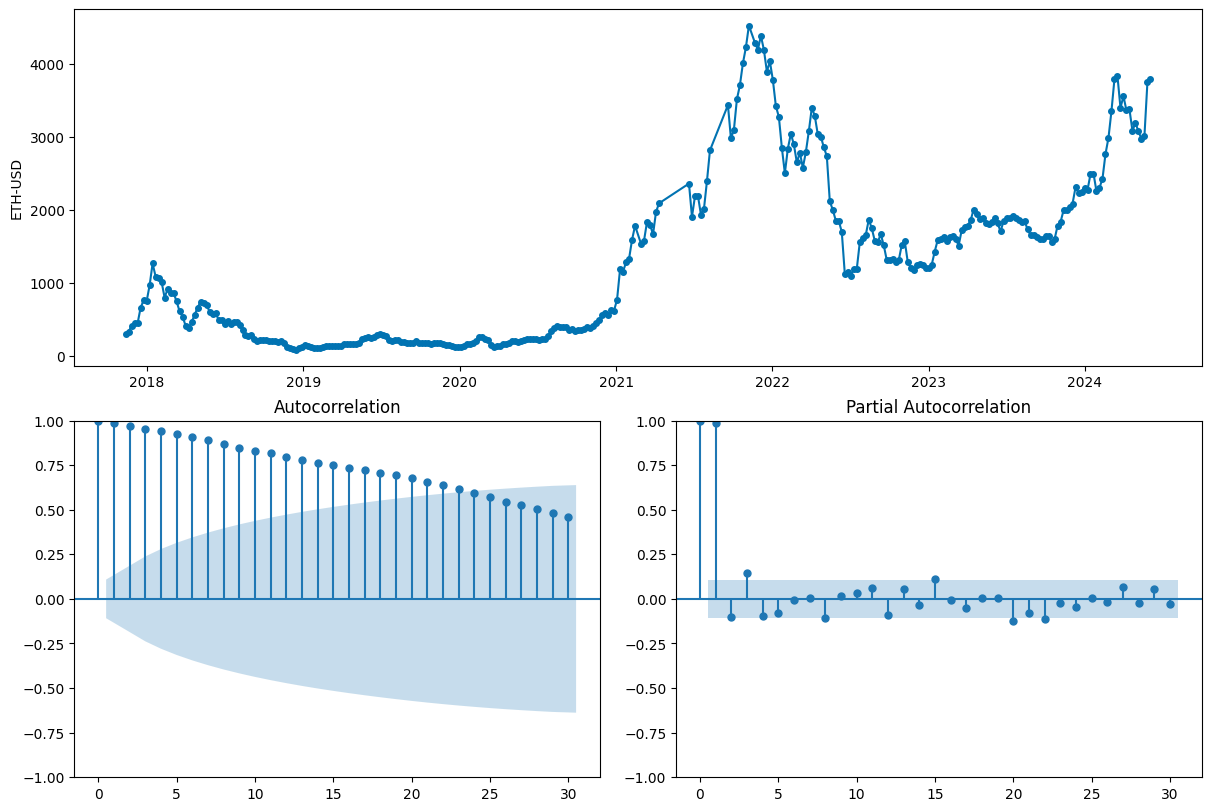

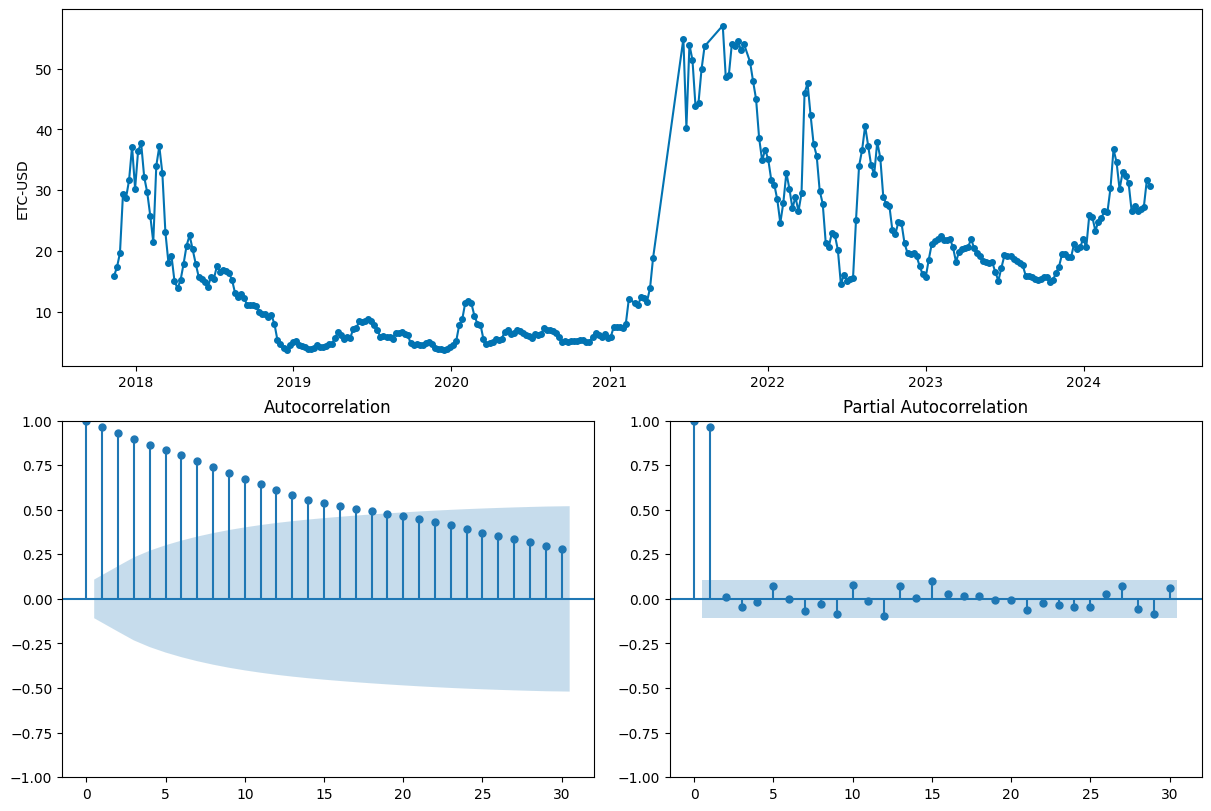

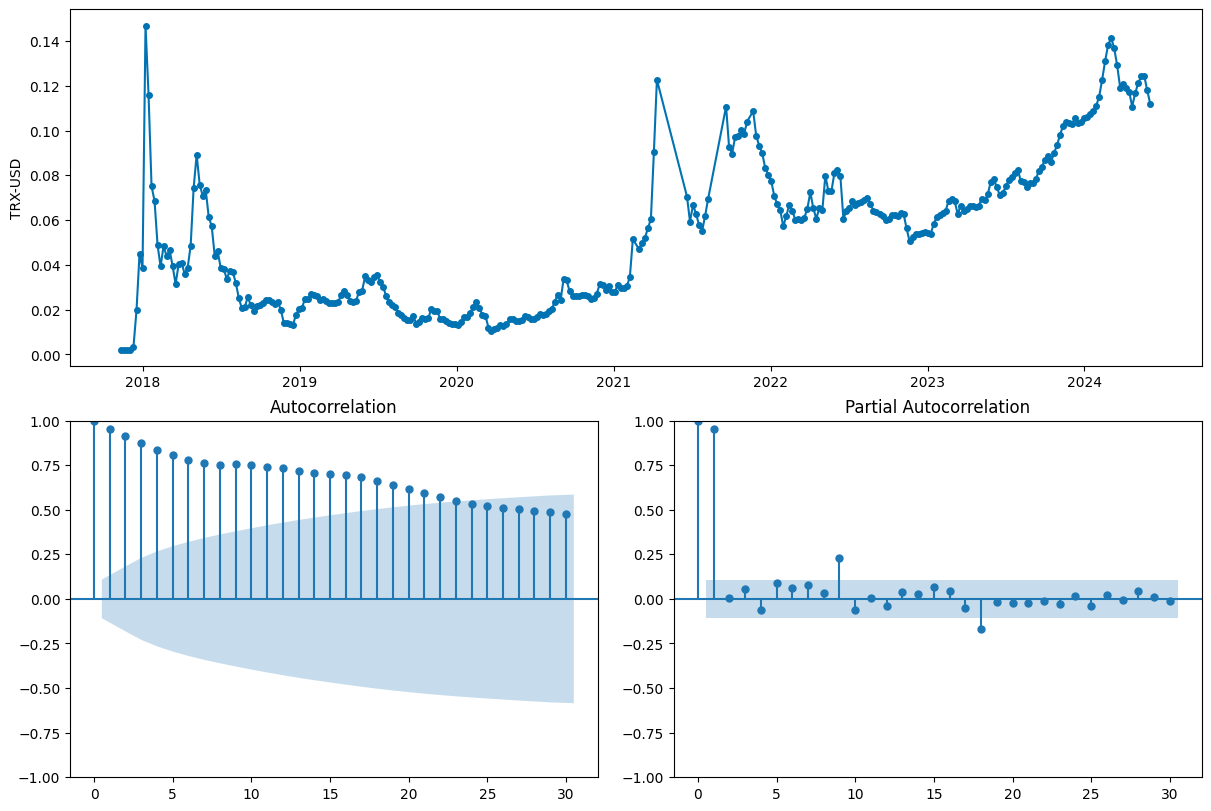

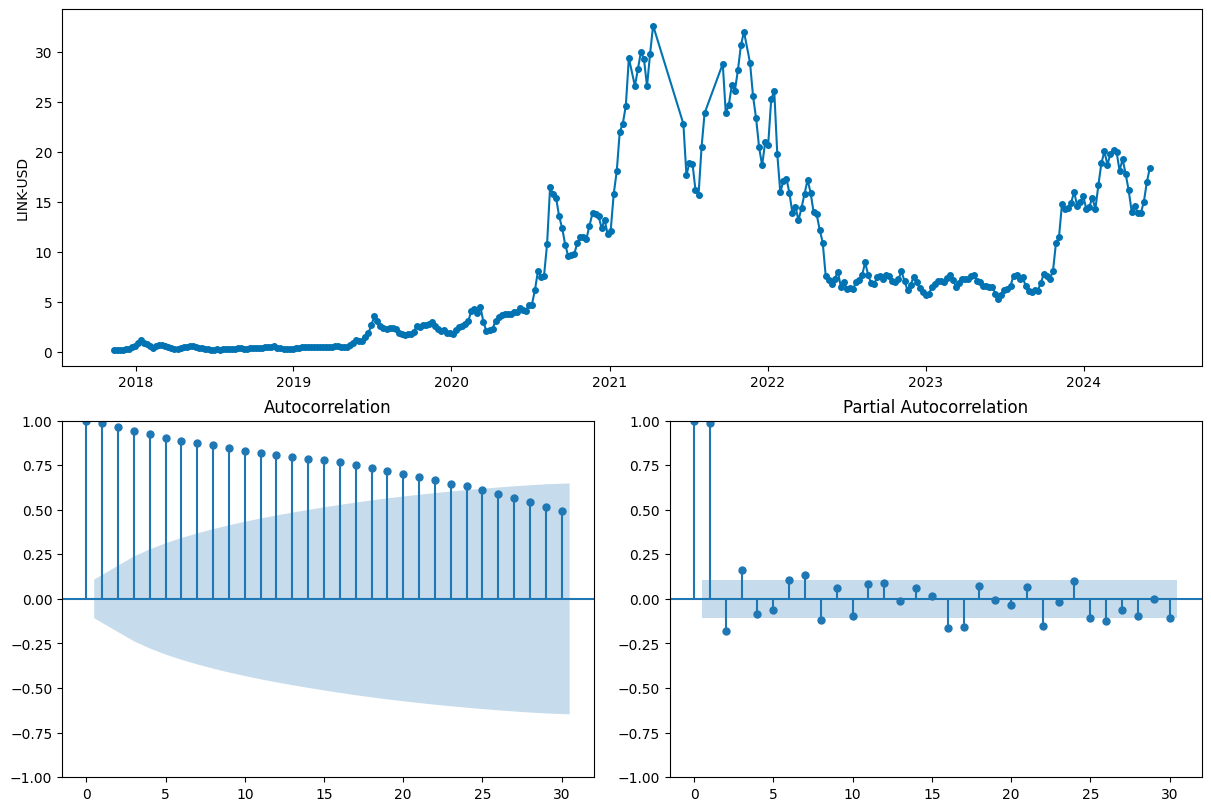

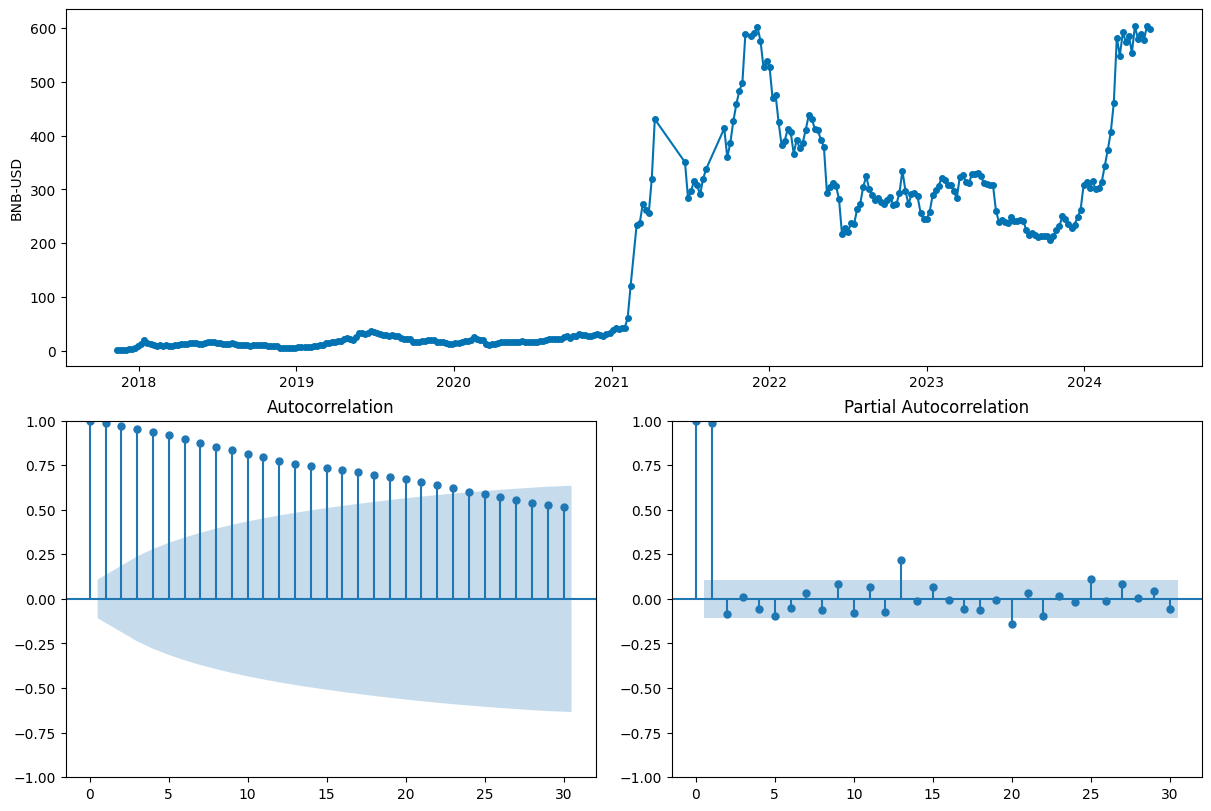

In [268]:
for i in prices.columns:
  plot_correlations(prices[i], lags=30)

По графикам автокорреляций видно, что у каждой криптовалюты присутствует достаточно сильная связь с прошлыми значениями, а значит для них хорошо будет применима VAR-модель, которая использует прошлые значения для прогнозирования

### Дополнительные фичи

Создадим дополнтительные признаки для улучшения качества прогнозов
1) Ставка по 13-недельным облигациям США - самые краткосрочные

In [269]:
features = pd.DataFrame()
for i in prices.columns:
  features['MA_'+i] = prices[i].rolling(window=13).mean()
  delta = prices[i].diff()
  window=13
  features['RSI_'+i] = 100 - (100 / (1 + (delta.where(delta > 0, 0)).fillna(0).rolling(window=window).mean() / (-delta.where(delta < 0, 0)).fillna(0).rolling(window=window).mean()))
  short_ema = prices[i].ewm(span=13, adjust=False).mean()  # Короткий период (13 недель - квартал)
  long_ema = prices[i].ewm(span=26, adjust=False).mean()   # Длинный период (26 недель - полгода)
  #features['MACD_'+i] = short_ema - long_ema

features['IRX'] = yf.download('^IRX', start = '2009-01-01', end = '2024-06-01', auto_adjust=True)['Close'].resample('D').ffill().resample('W').mean()
features['FVX'] = yf.download('^FVX', start = '2009-01-01', end = '2024-06-01', auto_adjust=True)['Close'].resample('D').ffill().resample('W').mean()
features['Gold'] = yf.download('GC=F', start = '2009-01-01', end = '2024-06-01', auto_adjust=True)['Close'].resample('D').ffill().resample('W').mean()
features['Brent'] = yf.download('BZ=F', start = '2009-01-01', end = '2024-06-01', auto_adjust=True)['Close'].resample('D').ffill().resample('W').mean()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [270]:
from statsmodels.tsa.stattools import adfuller
for i in prices.columns:
  if adfuller(prices.pct_change().dropna()[i])[1]<0.05:
    print('Ряд стационарен')
  else:
    print('Ряд нестационарен')

Ряд стационарен
Ряд стационарен
Ряд стационарен
Ряд стационарен
Ряд стационарен
Ряд стационарен


In [271]:
var_predicts = []
xgb_predicts = []
features = features[features.index.isin(prices.index)]
dataset = (pd.concat([prices.pct_change(), features], axis=1)).dropna()
#dataset = dataset.diff().dropna()

for i in prices.columns:
  y = dataset[i][1:]
  X = dataset.drop([i], axis=1).shift(1).dropna()
  X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)
  XGB = xgb.XGBRegressor()
  XGB.fit(X_train, y_train)
  y_pred = XGB.predict(X_test)
  xgb_predicts.append(y_pred)

var = VAR(dataset.dropna().iloc[:len(y_train), :])
results = var.fit(ic='bic')
lag_order = results.k_ar
forecast = results.forecast(dataset.values[-lag_order:], len(y_test)).T
for i in range(len(prices.columns)):
  var_predicts.append(forecast[i])


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


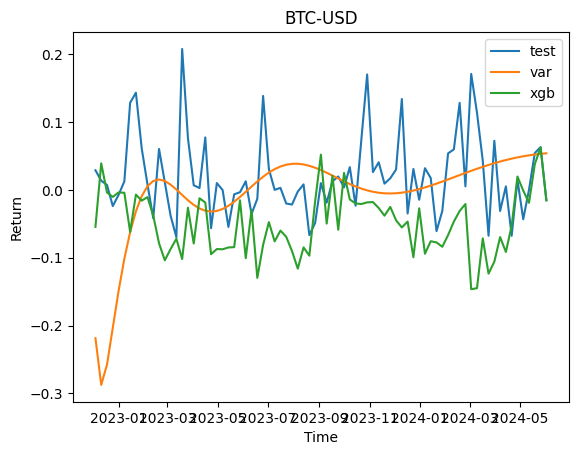

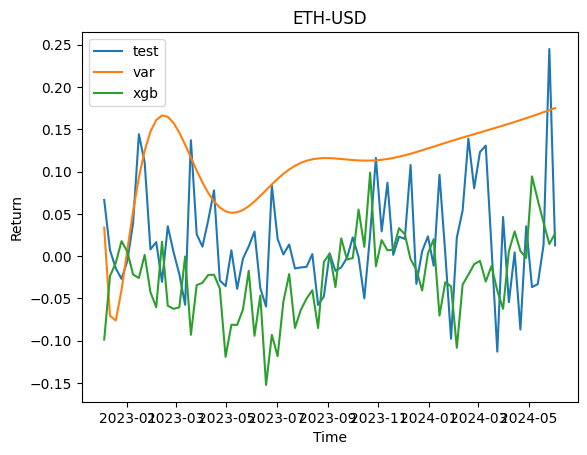

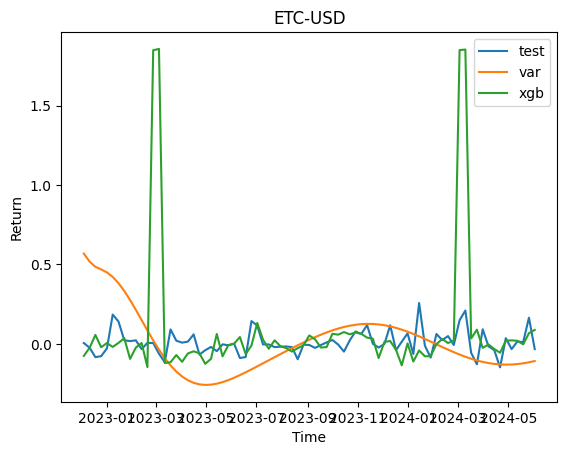

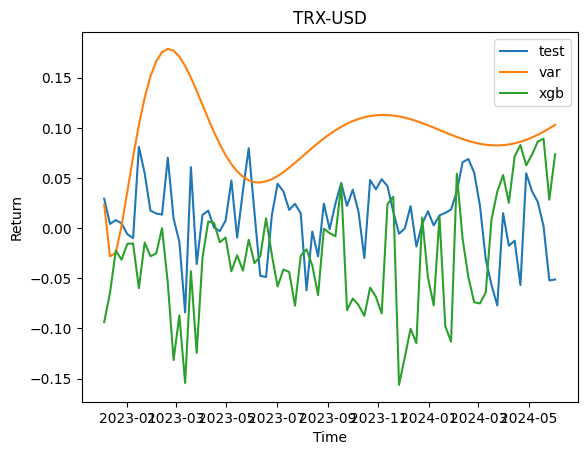

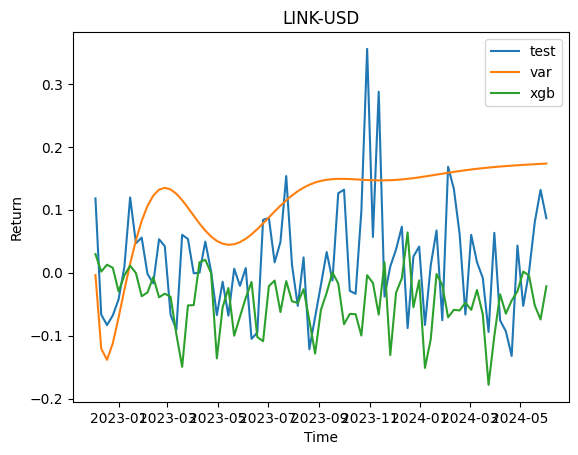

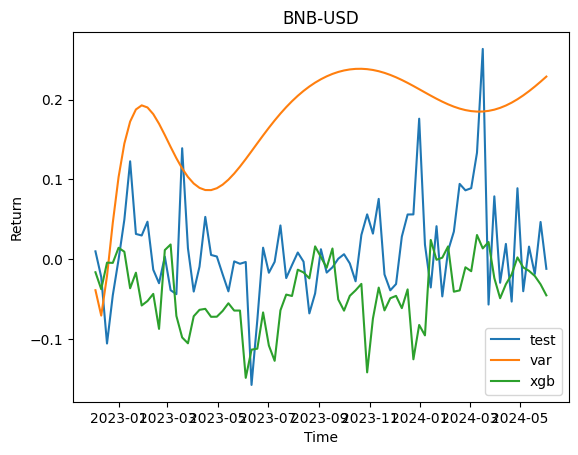

In [272]:
var_predicts = np.array(var_predicts)
xgb_predicts = np.array(xgb_predicts)
for i in range(len(prices.columns)):
  plt.title(prices.columns[i])
  plt.xlabel('Time')
  plt.ylabel('Return')
  plt.plot(dataset.iloc[-len(y_test):, i], label='test')
  plt.plot(pd.Series(var_predicts[i].T, index=y_test.index), label='var')
  plt.plot(pd.Series(xgb_predicts[i].T, index=y_test.index), label='xgb')
  plt.legend()
  plt.show()

In [273]:
y = dataset.iloc[-len(y_test):, :6]
wape_var = (y - var_predicts.T).abs().sum(axis=0)/y.sum(axis=0)
wape_xgb = (y - xgb_predicts.T).abs().sum(axis=0)/y.sum(axis=0)

In [274]:
wape_var, wape_xgb

(BTC-USD      3.260775
 ETH-USD      6.105641
 ETC-USD     18.339821
 TRX-USD      8.102571
 LINK-USD     7.103529
 BNB-USD     15.223546
 dtype: float64,
 BTC-USD      3.762925
 ETH-USD      4.110487
 ETC-USD     18.008913
 TRX-USD      6.464702
 LINK-USD     5.233802
 BNB-USD      6.360829
 dtype: float64)

In [275]:
var_features = []
var = VAR(dataset.dropna().iloc[:len(y_train), :])
results = var.fit(ic='bic')
lag_order = results.k_ar
forecast = results.forecast(dataset.values[-lag_order:], dataset.values.shape[0]).T
for i in range(len(prices.columns)):
  var_features.append(forecast[i])
var_features = np.array(var_features)

dataset = (pd.concat([dataset, pd.DataFrame(var_features.T, index=dataset.index)], axis=1)).dropna()

xgb_var_predicts = []
for i in prices.columns:
  y = dataset[i][1:]
  X = dataset.drop([i], axis=1).shift(1).dropna()
  X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)
  XGB = xgb.XGBRegressor()
  XGB.fit(X_train, y_train)
  y_pred = XGB.predict(X_test)
  xgb_var_predicts.append(y_pred)
xgb_var_predicts = np.array(xgb_var_predicts)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [276]:
y = dataset.iloc[-len(y_test):, :6]
wape_xgb_var = (y - xgb_var_predicts.T).abs().sum(axis=0)/y.sum(axis=0)
wape_xgb_var

BTC-USD      2.869190
ETH-USD      3.702982
ETC-USD     17.079976
TRX-USD      4.917257
LINK-USD     5.802539
BNB-USD      8.039125
dtype: float64

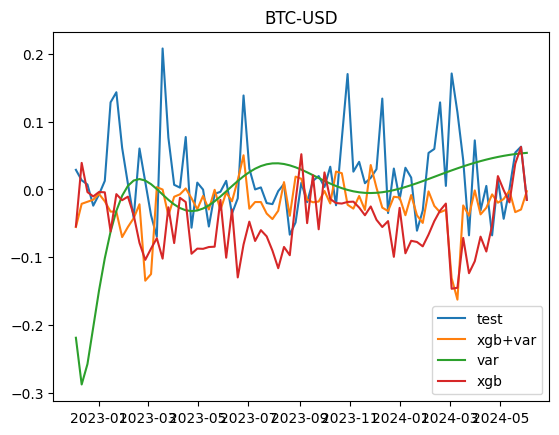

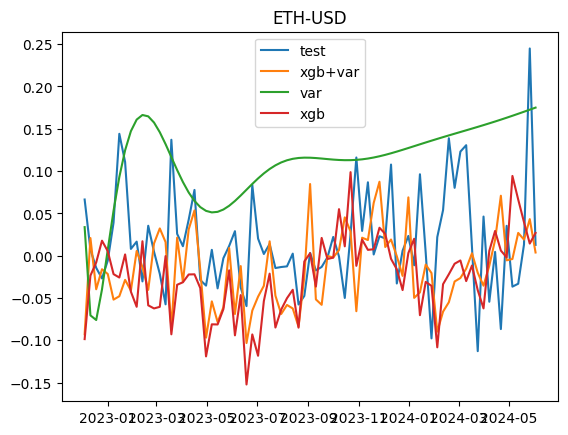

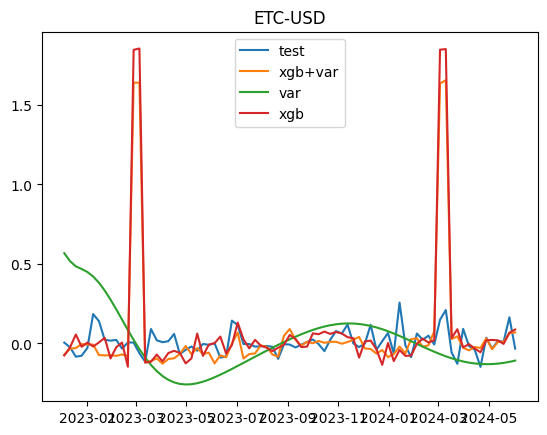

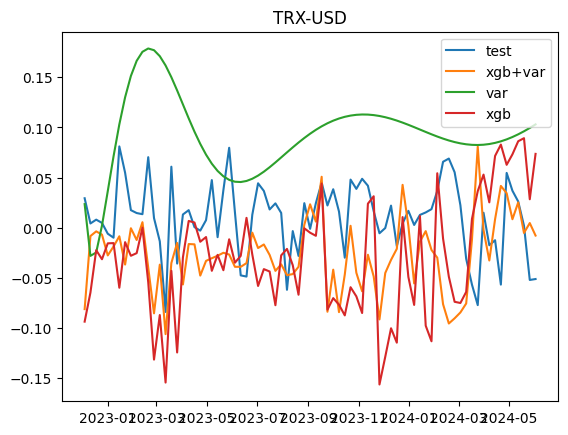

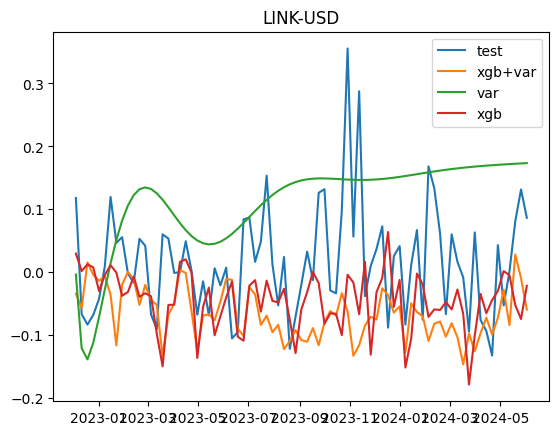

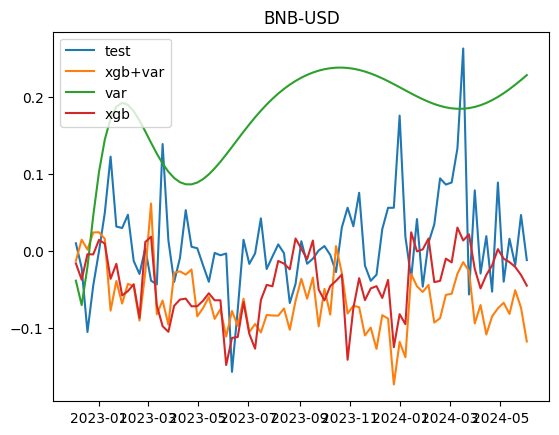

In [277]:
for i in range(len(prices.columns)):
  plt.title(prices.columns[i])
  plt.plot(dataset.iloc[-len(y_test):, i], label='test')
  plt.plot(pd.Series(xgb_var_predicts[i].T, index=y_test.index), label='xgb+var')
  plt.plot(pd.Series(var_predicts[i].T, index=y_test.index), label='var')
  plt.plot(pd.Series(xgb_predicts[i].T, index=y_test.index), label='xgb')
  plt.legend()
  plt.show()

In [278]:
for i in range(len(wape_var)):
  print(mean_squared_error(y.iloc[:, i], var_predicts[i]), mean_squared_error(y.iloc[:, i], xgb_predicts[i]), mean_squared_error(y.iloc[:, i], xgb_var_predicts[i]))


0.008247739922458086 0.010280086045834953 0.006900908300788083
0.014162134025611605 0.0074581962482749425 0.00682180617388287
0.040971275053102114 0.16763411511947213 0.13262368278188014
0.009224345808578852 0.006289456283813868 0.004137434091772531
0.01906024041660689 0.012389249425210101 0.015820717527748027
0.0322617094461688 0.007863900492370271 0.011305323739818664
